In [10]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# For the sack of reproducability
torch.manual_seed(42)

In [11]:
if torch.cuda.is_available():
    device = 'cuda'
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    print("Using CPU")

Using GPU: Tesla T4


In [3]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])


batch_size = 128

train_ds = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_tfms)
test_ds = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_tfms)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size*2, num_workers=2)

print("Images loaded.")
print("Training set size:", len(train_ds))
print("Test set size:", len(test_ds))

100%|██████████| 169M/169M [00:03<00:00, 48.4MB/s]


Images loaded.
Training set size: 50000
Test set size: 10000


In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ProjectCNN(nn.Module):

    def __init__(self):
        super(ProjectCNN, self).__init__()



        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)


        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)

        self.flatten = Flatten()
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.drop = nn.Dropout(0.4) # Dropout to stop the overfitting of the model
        self.fc2 = nn.Linear(1024, 100)




    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))

        x = self.flatten(x)
        x = self.drop(self.fc1(x))
        x = self.fc2(x)
        return x

model = ProjectCNN()
model = model.to(device)
print(model)

ProjectCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (re

In [5]:
learning_rate = 0.001
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# I read that scheduler helps with accuracy
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs)

### Training and Evaluation part of the model

In [6]:
train_losses = []
val_accuracies = []

print("Starting training...")

for epoch in range(epochs):

    # --- TRAINING ---
    model.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} done. Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.2f}%")

print("Finished Training")

Starting training...
Epoch 1 done. Loss: 3.7108, Val Acc: 21.51%
Epoch 2 done. Loss: 3.0382, Val Acc: 26.45%
Epoch 3 done. Loss: 2.6927, Val Acc: 33.03%
Epoch 4 done. Loss: 2.5596, Val Acc: 36.76%
Epoch 5 done. Loss: 2.5230, Val Acc: 37.30%
Epoch 6 done. Loss: 2.5440, Val Acc: 35.70%
Epoch 7 done. Loss: 2.5148, Val Acc: 36.57%
Epoch 8 done. Loss: 2.4900, Val Acc: 37.26%
Epoch 9 done. Loss: 2.4495, Val Acc: 37.67%
Epoch 10 done. Loss: 2.4063, Val Acc: 36.54%
Epoch 11 done. Loss: 2.3515, Val Acc: 38.62%
Epoch 12 done. Loss: 2.3019, Val Acc: 37.97%
Epoch 13 done. Loss: 2.2399, Val Acc: 40.23%
Epoch 14 done. Loss: 2.1638, Val Acc: 42.64%
Epoch 15 done. Loss: 2.0748, Val Acc: 44.65%
Epoch 16 done. Loss: 1.9817, Val Acc: 35.65%
Epoch 17 done. Loss: 1.8865, Val Acc: 49.42%
Epoch 18 done. Loss: 1.7737, Val Acc: 50.78%
Epoch 19 done. Loss: 1.6517, Val Acc: 53.96%
Epoch 20 done. Loss: 1.5331, Val Acc: 57.09%
Epoch 21 done. Loss: 1.4072, Val Acc: 57.96%
Epoch 22 done. Loss: 1.2998, Val Acc: 59.98

###Plotting the Curve

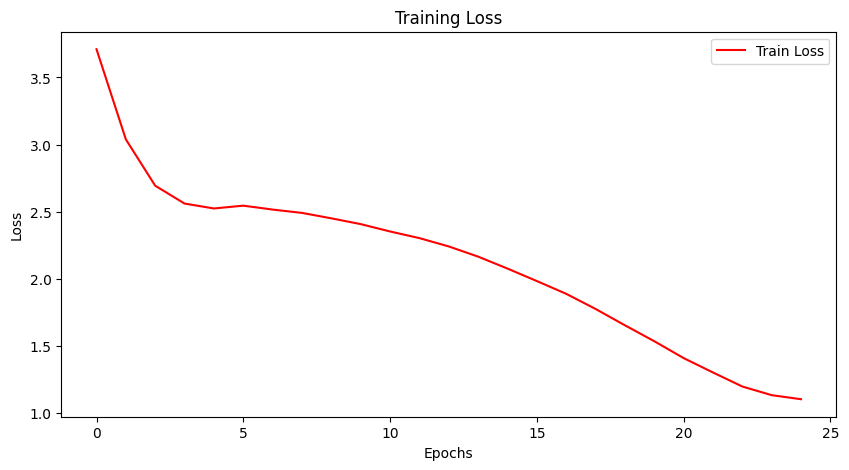

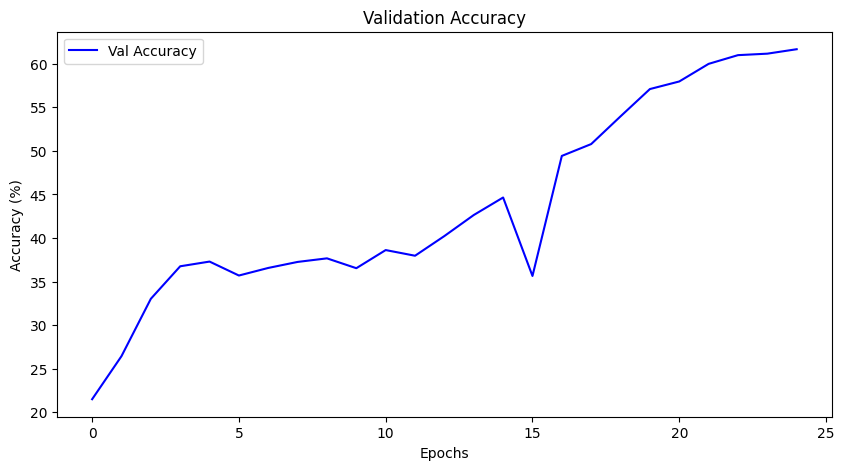

In [7]:
import matplotlib.pyplot as plt

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.title("Training Loss")
plt.plot(train_losses, label="Train Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.title("Validation Accuracy")
plt.plot(val_accuracies, label="Val Accuracy", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [9]:
torch.save(model.state_dict(), 'cifar100_custom_model.pth')
print("Model saved")

Model saved
